<a href="https://colab.research.google.com/github/mezkymy/global-salaries/blob/main/global-salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# load data
account = 'mezkymy'
repo = 'global-salaries'
branch = 'main'
data_file_name = 'salaries.csv'

url = str(f'https://raw.githubusercontent.com/{account}/{repo}/{branch}/{data_file_name}')

raw_data = pd.read_csv(url)
df = raw_data.copy()
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M


In [8]:
# basic informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8805 entries, 0 to 8804
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           8805 non-null   int64 
 1   experience_level    8805 non-null   object
 2   employment_type     8805 non-null   object
 3   job_title           8805 non-null   object
 4   salary              8805 non-null   int64 
 5   salary_currency     8805 non-null   object
 6   salary_in_usd       8805 non-null   int64 
 7   employee_residence  8805 non-null   object
 8   remote_ratio        8805 non-null   int64 
 9   company_location    8805 non-null   object
 10  company_size        8805 non-null   object
dtypes: int64(4), object(7)
memory usage: 756.8+ KB


In [9]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,8805.000000,8.805000e+03,8805.000000,8805.000000
mean,2022.737422,1.747287e+05,149488.265645,38.693924
std,0.542484,4.560690e+05,64222.105058,48.068060
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.055000e+05,105000.000000,0.000000
50%,2023.000000,1.441000e+05,142200.000000,0.000000
75%,2023.000000,1.900000e+05,185900.000000,100.000000
max,2023.000000,3.040000e+07,615201.000000,100.000000


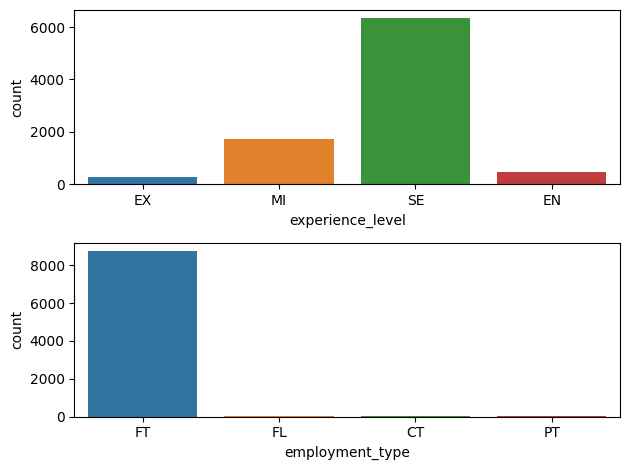

In [31]:
columns = df.columns
cat = [columns[1], columns[2]]
i = 0

fig, axes = plt.subplots(len(cat))

for col in cat:
    sns.countplot(df, ax=axes[i], x=col)
    i += 1

fig.tight_layout()
plt.show()

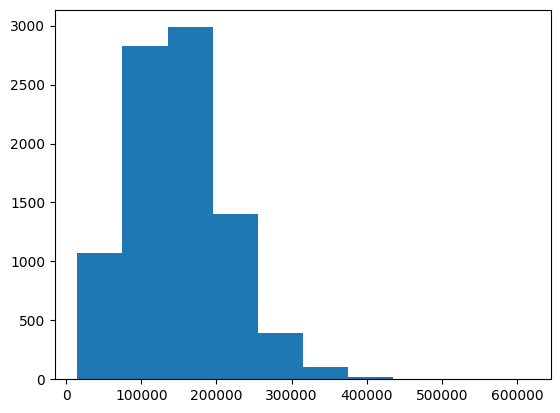

In [12]:
plt.hist(df.salary_in_usd)
plt.show()